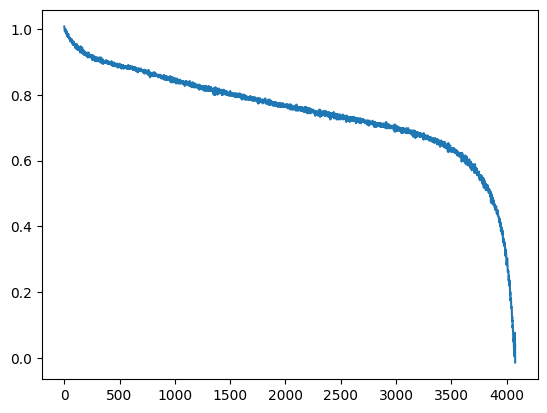

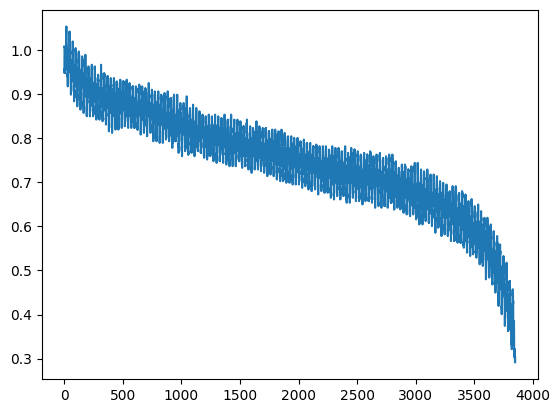

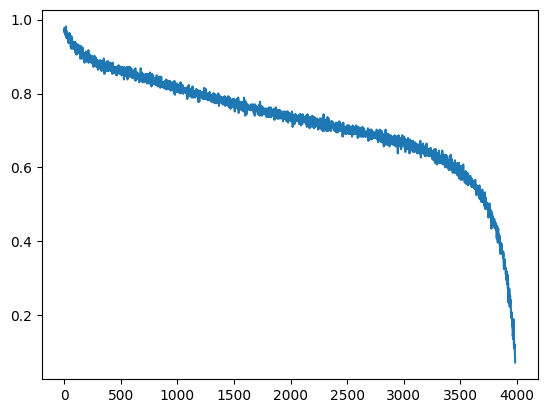

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import maketab as mt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import mean_squared_error, r2_score
plt.rcParams['mathtext.fontset'] = 'cm'
import gc
PATH = 'bat_pics/future/mlp/'
import time


sec_norm = 410
cutoff = 50 #cutting of time it takes to lift off
train_dir = (['data/24-1-25/', 'data/4-2-25/', 'data/5-2-25/'])
test_dir = (['data/31-1-25/', 'data/11-4-25/', 'data/9-4-25/'])
sig_norm = [3.7, 2.3]

def norm(signal, norm):
    signal = (signal - norm[1]) / (norm[0] - norm[1])
    return signal

def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    signal = norm(signal[cutoff:], sig_norm)
    return signal

for d in train_dir:
    data = load_data(d)
    plt.plot(data)
    plt.show()

In [2]:
class SequenceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        # The number of possible sequences is len(data) - 2 * sequence_length + 1
        return len(self.data) - 2 * self.sequence_length + 1

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.sequence_length]
        output_seq = self.data[idx + self.sequence_length : idx + 2 * self.sequence_length]
        return input_seq, output_seq

In [3]:
class FeedforwardModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.sig(x)
        x = self.fc2(x)
        return x

In [4]:
def train(num_epochs, dataloader, model, criterion, optimizer):
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0

        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(input_seq)
            loss = criterion(output, target_seq)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

            # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.8f}')

In [5]:
def predict(data, seq_length, theta, model, name, graph=True):
    model.eval()
    with torch.no_grad():
        pred = np.empty(0)
        for i in range(0, len(data) - seq_length + 1, seq_length*(theta+1)):
            X = torch.tensor(data[i:i+seq_length], dtype=torch.float32).unsqueeze(0)
            y = model(X)
            y_pred = y.squeeze(0).numpy()
            pred = np.append(pred, y_pred)
            for j in range(theta):
                y = model(y)
                y_pred = y.squeeze(0).numpy()
                pred = np.append(pred, y_pred)
                # if(len(data) <= i+(2*30*(j+1))):
                #     break
            plt.axvline(i+seq_length, linestyle=":", color="black", linewidth=0.5)

        pred = np.append(np.zeros(seq_length), pred)

        new_pred = pred[seq_length:len(data)]
        new_data = data[seq_length:]
        t = np.arange(0, len(new_data))
        #t = t/100
        plt.plot(t, new_data, label=r'$\hat{u}(t)$')
        plt.plot(t, new_pred, label=r'$y(t)$')
        if graph is True:
            plt.xlabel('t(s)')
            plt.legend(fontsize=16)
            plt.grid(True)
            plt.savefig(PATH+name+'.pdf')
            plt.close()
        # mse = mean_squared_error(new_data, new_pred)
        # r2 = r2_score(new_data, new_pred)
        return new_data, new_pred

In [6]:
def test_model(seq_length, hidden_size, num_epochs, batch_size, learning_rate, theta):
    train_data1 = load_data(train_dir[0])
    dataset1 = SequenceDataset(train_data1, seq_length)
    train_data2 = load_data(train_dir[1])
    dataset2 = SequenceDataset(train_data2, seq_length)
    train_data3 = load_data(train_dir[2])
    dataset3 = SequenceDataset(train_data3, seq_length)
    
    combined_dataset = ConcatDataset([dataset1, dataset2, dataset3])
    dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

    test_data1 = load_data(test_dir[0])
    test_data2 = load_data(test_dir[1])
    test_data3 = load_data(test_dir[2])
    
    model = FeedforwardModel(seq_length, hidden_size, seq_length)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    start_time = time.time()
    train(num_epochs, dataloader, model, criterion, optimizer)
    end_time = time.time()
    print(f"Training completed in {(end_time - start_time):.4f} seconds")

    data1, pred1 = predict(train_data1, seq_length, theta, model, 'train1_'+str(seq_length)+str(hidden_size)+str(theta), graph=True)
    data2, pred2 = predict(train_data2, seq_length, theta, model, 'train2_'+str(seq_length)+str(hidden_size)+str(theta), graph=True)
    data3, pred3 = predict(train_data3, seq_length, theta, model, 'train3_'+str(seq_length)+str(hidden_size)+str(theta), graph=True)

    data = np.concatenate([data1, data2, data3])
    pred = np.concatenate([pred1, pred2, pred3])

    mse1 = mean_squared_error(data, pred)
    r21 = r2_score(data, pred)


    data1, pred1 = predict(test_data1, seq_length, theta, model, 'test1_'+str(seq_length)+str(hidden_size)+str(theta), graph=True)
    data2, pred2 = predict(test_data2, seq_length, theta, model, 'test2_'+str(seq_length)+str(hidden_size)+str(theta), graph=True)
    data3, pred3 = predict(test_data3, seq_length, theta, model, 'test3_'+str(seq_length)+str(hidden_size)+str(theta), graph=True)

    data = np.concatenate([data1, data2, data3])
    pred = np.concatenate([pred1, pred2, pred3])

    mse2 = mean_squared_error(data, pred)
    r22 = r2_score(data, pred)

    del model, criterion, optimizer
    gc.collect()

    return seq_length, hidden_size, learning_rate, theta, mse1, mse2, r21, r22, (end_time - start_time)

In [7]:
if __name__ == "__main__":
    rows = []
    columns = ['n', 'k', 'lr', 'theta', 'train_mse', 'test_mse', 'train_r2', 'test_r2', 'time']
    #test_model(seq_length, hidden_size, num_epochs, batch_size, learning_rate, theta)
    rows.append(test_model(50, 70, 100, 16, 0.001, 30))
    rows.append(test_model(70, 30, 100, 16, 0.001, 30))

    df = pd.DataFrame(rows, columns=columns)
    scale_cols = ['train_mse', 'test_mse', 'train_r2', 'test_r2']
    df[scale_cols] = (df[scale_cols] * 1000).round(2)
    df['time'] = df['time'].round(1)

    df.insert(3, 'sigma', r'\text{ReLU}')
    
    print(df)
    df['lr'] = '10^{-3}'
    print("    ")
    print("\n".join("&".join(f"{{${val}$}}" for val in row) + "\\\\" for _, row in df.iterrows()))

Epoch [10/100], Loss: 0.00019237
Epoch [20/100], Loss: 0.00013455
Epoch [30/100], Loss: 0.00011370
Epoch [40/100], Loss: 0.00010479
Epoch [50/100], Loss: 0.00009826
Epoch [60/100], Loss: 0.00009563
Epoch [70/100], Loss: 0.00009411
Epoch [80/100], Loss: 0.00009377
Epoch [90/100], Loss: 0.00009265
Epoch [100/100], Loss: 0.00009301
Training completed in 46.0496 seconds
Epoch [10/100], Loss: 0.00028200
Epoch [20/100], Loss: 0.00014368
Epoch [30/100], Loss: 0.00012254
Epoch [40/100], Loss: 0.00010316
Epoch [50/100], Loss: 0.00009699
Epoch [60/100], Loss: 0.00009129
Epoch [70/100], Loss: 0.00008873
Epoch [80/100], Loss: 0.00008655
Epoch [90/100], Loss: 0.00008644
Epoch [100/100], Loss: 0.00008424
Training completed in 44.8090 seconds
    n   k     lr        sigma  theta  train_mse  test_mse  train_r2  test_r2  \
0  50  70  0.001  \text{ReLU}     30      51.32    160.55  -1878.95 -7168.66   
1  70  30  0.001  \text{ReLU}     30       9.27     42.76    475.49 -1197.03   

   time  
0  46.0  
1